In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 
import nltk.stem.porter
porter_stemmer=nltk.stem.porter.PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
emails = pd.read_csv('../input/tedtalk/split_emails.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


In [103]:
email_df = pd.DataFrame(parse_into_emails(emails.message))


In [106]:
email_df.head(5)

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com


In [104]:
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [ ]:
#finding top words
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"

In [107]:
email_df.head()

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com


In [109]:
#stemming
body = email_df.body
def stemmingDF(body):
    bigl=[]
    for string in body:
        lis=string.split()
        l=[]
        for word in lis:
            if word.isalpha()==True:                
                if word not in stopwords:
                    if len(word)!=1:
                        word=word.lower()
                        word=lemmatizer.lemmatize(word)
                        l.append(word)
        str1=' '.join(l)
        bigl.append(str1)
    return bigl

email_df["body_new"] = stemmingDF(body)



In [110]:
email_df.body_new[1]

'traveling business meeting take fun especially prepare suggest holding business plan meeting trip formal business try honest opinion trip desired far business think productive try stimulate discussion different group working too presenter speaks quiet just waiting the meeting better held round table discussion suggestion play golf rent ski boat jet flying take'

In [ ]:
#print top features
X = vect.fit_transform(email_df.body_new)
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X.todense())
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

In [111]:
labels.shape

(9464,)

In [ ]:
labels.dtype

In [112]:
labels[:1000]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,

In [ ]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


In [ ]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

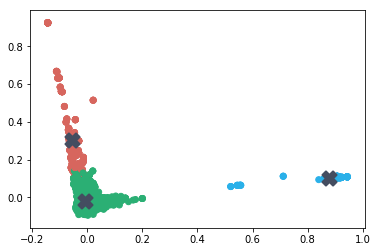

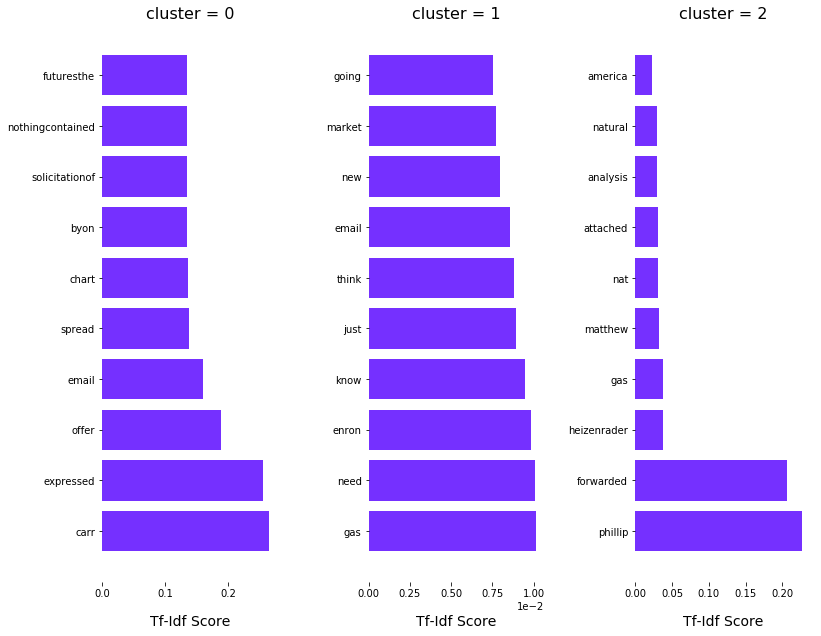

In [113]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 10))

In [ ]:
def cos_score(lst):   
    leve_m=np.zeros([10,10])
    for i,word1 in enumerate(lst['features']):
        for j,word2 in enumerate(lst['features']):
            if word1!=word2:
                leve_m[i][j]=linear_kernel(lst['score'][i].reshape(-1,1),lst['score'][j].reshape(-1,1)).flatten()
    return leve_m.mean()

In [ ]:
lst0=top_feats_per_cluster(X,labels,features,0.1,10)[0]
lst1=top_feats_per_cluster(X,labels,features,0.1,10)[1]
lst2=top_feats_per_cluster(X,labels,features,0.1,10)[2]

In [93]:
lst0.shape

(10, 2)

In [ ]:
zero=lst0.score[0].reshape(-1,1)
one=lst0.score[1].reshape(-1,1)
linear_kernel(zero,one).flatten()

In [ ]:
score0=cos_score(lst0)
score1=cos_score(lst1)
score2=cos_score(lst2)

In [91]:
print(score0,score1,score2)

0.025117958053310435 7.112289341747545e-05 0.0036823345718200984


In [ ]:
print(score0)
print(score1)
print(score2)

In [ ]:
X_new=X.todense()
from scipy.cluster import hierarchy
Z=hierarchy.linkage(X_new, 'ward')



In [ ]:

dn = hierarchy.dendrogram(Z)
#dendrogram=sch.dendrogram(sch,linkage(X,method='ward'))
plt.title('Dendrogram')
#plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.xlim(0,5000)
plt.ylim(0,15)
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_new)

In [115]:
y_hc.shape

(9464,)

In [ ]:
y_hc.dtype

In [ ]:
y_hc1=y_hc.astype(np.int32)

In [ ]:
y_hc1.dtype

In [114]:
y_hc1[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [ ]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, y_hc1, features, 0.1, 10))

In [96]:
from sklearn.metrics.pairwise import linear_kernel
def cos_score(lst):   
    leve_m=np.zeros([10,10])
    for i,word1 in enumerate(lst['features']):
        for j,word2 in enumerate(lst['features']):
            if word1!=word2:
                leve_m[i][j]=linear_kernel(lst['score'][i].reshape(-1,1),lst['score'][j].reshape(-1,1)).flatten()
    return leve_m.mean()

In [97]:
lst0=top_feats_per_cluster(X,y_hc1,features,0.1,10)[0]
lst1=top_feats_per_cluster(X,y_hc1,features,0.1,10)[1]
lst2=top_feats_per_cluster(X,y_hc1,features,0.1,10)[2]


In [98]:
lst0.index

RangeIndex(start=0, stop=10, step=1)

In [95]:
lst0

,features,score
0.0,phillip,0.013575
1.0,forwarded,0.012923
2.0,gas,0.011702
3.0,need,0.010021
4.0,enron,0.009411
5.0,know,0.009145
6.0,just,0.008647
7.0,think,0.008515
8.0,market,0.008478
9.0,email,0.008232


In [ ]:
lst0['score']

In [101]:
score0=cos_score(lst0)

score1=cos_score(lst1)
score2=cos_score(lst2)

In [102]:
print(score0)
print(score1)
print(score2)

9.082432437791355e-05
0.025117958053310435
0.04114665738172694
